# Machine Learning - CatBoost

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
required_libs = [ ("numpy", "numpy"),
                 ("pandas", "pandas"),
                 ("seaborn", "seaborn"),
                 ("matplotlib", "matplotlib"),
                 ("catboost", "catboost"),
                 ("sklearn", "sklearn"),
                 ("ipywidgets", "ipywidgets"),
                 ("shap", "shap"),
                 ("colorama", "colorama"),
                 ("emoji", "emoji")
                ]

In [3]:
def is_lib_exists(name):
    import importlib
    lib = importlib.util.find_spec(name)
    return lib is not None

In [4]:
for (clz,lib) in required_libs:
    if not is_lib_exists(clz):
        print(f"Installing {lib}")
        !pip install {lib}
    else:
        print(f"{lib} exists")

numpy exists
pandas exists
seaborn exists
matplotlib exists
catboost exists
sklearn exists
ipywidgets exists
shap exists
colorama exists
emoji exists


In [5]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import traceback
import catboost
from pathlib import Path
from dateutil.relativedelta import *
from datetime import *
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier
from scipy import stats
from scipy.stats.stats import pearsonr
np.set_printoptions(precision=4)
pd.options.display.max_columns = None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
%matplotlib inline
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [8]:
from IPython.display import display

In [9]:
# check catboost version
print(catboost.__version__)
!python --version

0.24.1
Python 3.6.9


In [10]:
# colab setup
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .
  
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

Cloning into 'dl-projects'...
remote: Enumerating objects: 2210, done.
remote: Total 2210 (delta 0), reused 0 (delta 0), pack-reused 2210
Receiving objects: 100% (2210/2210), 79.50 MiB | 28.56 MiB/s, done.
Resolving deltas: 100% (1379/1379), done.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 4948M
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr.ft
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr_orig.pkl
-rw------- 1 root root   17M Mar  1 05:47 feature_matrix_2020_feb.ft
-rw------- 1 root root   17M Mar  1 05:39 feature_matrix_2020_jan.ft
-rw------- 1 root root   17M Jul  7 13:52 feature_matrix_2020_jul.ft
-rw------- 1 root root   17M Jul  7 13:52 feature_matrix_2020_jul_orig.pkl
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_jun.ft
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_jun_orig.pkl
-rw------- 1 root root   17M Jul  6 13:

## EDA

In [11]:
from preprocess import *
from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labeled_scatter

In [12]:
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [13]:
jan_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jan.ft")
feb_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_feb.ft")
mar_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_mar.ft")
apr_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_apr.ft")
may_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_may.ft")
jun_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jun.ft")
jul_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jul.ft")

In [14]:
new_data = data.append(jan_2020[data.columns],ignore_index=True)
new_data = new_data.append(feb_2020[data.columns],ignore_index=True)
new_data = new_data.append(mar_2020[data.columns],ignore_index=True)
new_data = new_data.append(apr_2020[data.columns],ignore_index=True)
new_data = new_data.append(may_2020[data.columns],ignore_index=True)
new_data = new_data.append(jun_2020[data.columns],ignore_index=True)
new_data = new_data.append(jul_2020[data.columns],ignore_index=True)
data.shape, new_data.shape 

((959893, 217), (1029893, 217))

In [15]:
data = new_data

In [16]:
data.isna().sum().sort_values(ascending=False)

CUM_SUM(SKEW(Results.TotalStrike))           7685
CUM_MEAN(TREND(Results.DrawNo, DrawDate))    7685
TREND(Results.CUM_SUM(DrawNo), DrawDate)     7685
TREND(Results.CUM_SUM(LuckyNo), DrawDate)    7685
CUM_SUM(SKEW(Results.LuckyNo))               7685
                                             ... 
CUM_SUM(MIN(Results.DrawNo))                    0
NUM_UNIQUE(Results.DAY(DrawDate))               0
NUM_UNIQUE(Results.MONTH(DrawDate))             0
SUM(Results.PERCENTILE(LuckyNo))                0
NumberId                                        0
Length: 217, dtype: int64

In [17]:
data.info(max_cols=500, null_counts=True)
#data.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029893 entries, 0 to 1029892
Data columns (total 217 columns):
 #   Column                                                  Non-Null Count    Dtype         
---  ------                                                  --------------    -----         
 0   NumberId                                                1029893 non-null  int64         
 1   time                                                    1029893 non-null  datetime64[ns]
 2   STD(Results.DrawNo)                                     1028948 non-null  float64       
 3   STD(Results.TotalStrike)                                1028948 non-null  float64       
 4   STD(Results.LuckyNo)                                    1028948 non-null  float64       
 5   MAX(Results.DrawNo)                                     1029893 non-null  int64         
 6   MAX(Results.TotalStrike)                                1029893 non-null  int64         
 7   MAX(Results.LuckyNo)               

In [18]:
feature_matrix = data
feature_matrix = data.fillna(0)
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.head(20)

,NumberId,time,STD(Results.DrawNo),STD(Results.TotalStrike),STD(Results.LuckyNo),MAX(Results.DrawNo),MAX(Results.TotalStrike),MAX(Results.LuckyNo),MIN(Results.DrawNo),MIN(Results.TotalStrike),MIN(Results.LuckyNo),MEAN(Results.DrawNo),MEAN(Results.TotalStrike),MEAN(Results.LuckyNo),SKEW(Results.DrawNo),SKEW(Results.TotalStrike),SKEW(Results.LuckyNo),LAST(Results.results_index),LAST(Results.DrawNo),LAST(Results.TotalStrike),LAST(Results.LuckyNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.TotalStrike),SUM(Results.LuckyNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),MONTH(first_Results_time),DAY(first_Results_time),TIME_SINCE(first_Results_time),TIME_SINCE_PREVIOUS(first_Results_time),STD(Results.TIME_SINCE(DrawDate)),STD(Results.CUM_MEAN(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.TIME_SINCE_PREVIOUS(DrawDate)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_SUM(DrawNo)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),MAX(Results.TIME_SINCE(DrawDate)),MAX(Results.CUM_MEAN(DrawNo)),MAX(Results.CUM_SUM(LuckyNo)),MAX(Results.PERCENTILE(DrawNo)),MAX(Results.TIME_SINCE_PREVIOUS(DrawDate)),MAX(Results.CUM_SUM(TotalStrike)),MAX(Results.PERCENTILE(TotalStrike)),MAX(Results.CUM_SUM(DrawNo)),MAX(Results.CUM_MEAN(LuckyNo)),MAX(Results.CUM_MEAN(TotalStrike)),MAX(Results.PERCENTILE(LuckyNo)),MIN(Results.TIME_SINCE(DrawDate)),MIN(Results.CUM_MEAN(DrawNo)),MIN(Results.CUM_SUM(LuckyNo)),MIN(Results.PERCENTILE(DrawNo)),MIN(Results.TIME_SINCE_PREVIOUS(DrawDate)),MIN(Results.CUM_SUM(TotalStrike)),MIN(Results.PERCENTILE(TotalStrike)),MIN(Results.CUM_SUM(DrawNo)),MIN(Results.CUM_MEAN(LuckyNo)),MIN(Results.CUM_MEAN(TotalStrike)),MIN(Results.PERCENTILE(LuckyNo)),MODE(Results.MONTH(DrawDate)),MODE(Results.DAY(DrawDate)),MEAN(Results.TIME_SINCE(DrawDate)),MEAN(Results.CUM_MEAN(DrawNo)),MEAN(Results.CUM_SUM(LuckyNo)),MEAN(Results.PERCENTILE(DrawNo)),MEAN(Results.TIME_SINCE_PREVIOUS(DrawDate)),MEAN(Results.CUM_SUM(TotalStrike)),MEAN(Results.PERCENTILE(TotalStrike)),MEAN(Results.CUM_SUM(DrawNo)),MEAN(Results.CUM_MEAN(LuckyNo)),MEAN(Results.CUM_MEAN(TotalStrike)),MEAN(Results.PERCENTILE(LuckyNo)),SKEW(Results.TIME_SINCE(DrawDate)),SKEW(Results.CUM_MEAN(DrawNo)),SKEW(Results.CUM_SUM(LuckyNo)),SKEW(Results.PERCENTILE(DrawNo)),SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate)),SKEW(Results.CUM_SUM(TotalStrike)),SKEW(Results.PERCENTILE(TotalStrike)),SKEW(Results.CUM_SUM(DrawNo)),SKEW(Results.CUM_MEAN(LuckyNo)),SKEW(Results.CUM_MEAN(TotalStrike)),SKEW(Results.PERCENTILE(LuckyNo)),LAST(Results.TIME_SINCE(DrawDate)),LAST(Results.CUM_MEAN(DrawNo)),LAST(Results.CUM_SUM(LuckyNo)),LAST(Results.PERCENTILE(DrawNo)),LAST(Results.DAY(DrawDate)),LAST(Results.TIME_SINCE_PREVIOUS(DrawDate)),LAST(Results.CUM_SUM(TotalStrike)),LAST(Results.MONTH(DrawDate)),LAST(Results.CUM_SUM(DrawNo)),LAST(Results.CUM_MEAN(LuckyNo)),LAST(Results.PERCENTILE(TotalStrike)),LAST(Results.CUM_MEAN(TotalStrike)),LAST(Results.PERCENTILE(LuckyNo)),SUM(Results.TIME_SINCE(DrawDate)),SUM(Results.CUM_MEAN(DrawNo)),SUM(Results.CUM_SUM(LuckyNo)),SUM(Results.PERCENTILE(DrawNo)),SUM(Results.TIME_SINCE_PREVIOUS(DrawDate)),SUM(Results.CUM_SUM(TotalStrike)),SUM(Results.PERCENTILE(TotalStrike)),SUM(Results.CUM_SUM(DrawNo)),SUM(Results.CUM_MEAN(LuckyNo)),SUM(Results.CUM_MEAN(TotalStrike)),SUM(Results.PERCENTILE(LuckyNo)),"TREND(Results.CUM_MEAN(LuckyNo), DrawDate)","TREND(Results.PERCENTILE(LuckyNo), DrawDate)","TREND(Results.PERCENTILE(DrawNo), DrawDate)","TREND(Results.CUM_MEAN(DrawNo), DrawDate)","TREND(Results.TIME_SINCE(DrawDate), DrawDate)","TREND(Results.CUM_SUM(TotalStrike), DrawDate)","TREND(Results.PERCENTILE(TotalStrike), DrawDate)","TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)","TREND(Results.CUM_MEAN(TotalStrike), DrawDate)","TREND(Results.CU

In [19]:
# https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

other_features = ['Label', 'NumberId', 'time', 'TotalStrike',  'month', 'year']
#feature_matrix = feature_selection(data)

def select_features(df, func=f_regression):
  X = df.drop(columns=other_features)
  y = df.Label
  fs = SelectKBest(score_func=func, k=50)
  X_selected = fs.fit_transform(X, y)
  mask = fs.get_support()
  return X.columns[mask]

def reduce_features(df, lower_threshold=10, upper_threshold=10000):
  cols_to_drop = []
  for col in df.columns:
    if df[col].nunique() > upper_threshold or df[col].nunique() < lower_threshold:
      cols_to_drop.append(col)
  print(cols_to_drop)
  return cols_to_drop, dfdrop(columns=cols_to_drop)

def select_by_variance(df, threshold=0):
  """Select features by variance"""
  filter = VarianceThreshold(threshold=threshold)
  filter.fit(df)
  cols_to_drop = [column for column in df.columns
                  if column not in df.columns[filter.get_support()]]
  print(f"No of columns to drop - {len(cols_to_drop)}")
  print(cols_to_drop)
  return cols_to_drop

def select_duplicates(df):
  df_transposed = df.head(20000).T
  print(df_transposed.duplicated().sum())
  unique_features = df_transposed.drop_duplicates(keep='first').T
  print(unique_features.shape)
  duplicated_features = [dup_col for dup_col in df.columns if dup_col not in unique_features.columns]
  return duplicated_features

def select_correlated(df):
  pass

In [20]:
import gc

#features = select_features(feature_matrix)
#numerical_features = features.to_list()

#gc.collect()

#features = select_features(feature_matrix, func=f_classif)
#numerical_features =  features.to_list()

#features = feature_selection(feature_matrix.drop(columns=other_features))
#numerical_features = features.columns.to_list()  

#features = feature_selection(feature_matrix.drop(columns=other_features))
#numerical_features = numerical_features + features.columns.to_list()  

#numerical_features = ['MAX(Results.CUM_SUM(DrawNo))', 'LAST(Results.CUM_SUM(DrawNo))', 'CUM_MEAN(MEAN(Results.DrawNo))', 'CUM_MEAN(LAST(Results.DrawNo))', 'CUM_MEAN(MAX(Results.DrawNo))', 'CUM_MEAN(COUNT(Results))', 'CUM_MEAN(SUM(Results.LuckyNo))', 'CUM_MEAN(STD(Results.DrawNo))', 'CUM_MEAN(SUM(Results.TotalStrike))', 'CUM_MEAN(SUM(Results.DrawNo))']

In [21]:
#selected_features = other_features + numerical_features
selected_features = feature_matrix.columns.to_list()
display(len(selected_features), selected_features)

217

['NumberId',
 'time',
 'STD(Results.DrawNo)',
 'STD(Results.TotalStrike)',
 'STD(Results.LuckyNo)',
 'MAX(Results.DrawNo)',
 'MAX(Results.TotalStrike)',
 'MAX(Results.LuckyNo)',
 'MIN(Results.DrawNo)',
 'MIN(Results.TotalStrike)',
 'MIN(Results.LuckyNo)',
 'MEAN(Results.DrawNo)',
 'MEAN(Results.TotalStrike)',
 'MEAN(Results.LuckyNo)',
 'SKEW(Results.DrawNo)',
 'SKEW(Results.TotalStrike)',
 'SKEW(Results.LuckyNo)',
 'LAST(Results.results_index)',
 'LAST(Results.DrawNo)',
 'LAST(Results.TotalStrike)',
 'LAST(Results.LuckyNo)',
 'AVG_TIME_BETWEEN(Results.DrawDate)',
 'COUNT(Results)',
 'SUM(Results.DrawNo)',
 'SUM(Results.TotalStrike)',
 'SUM(Results.LuckyNo)',
 'TREND(Results.TotalStrike, DrawDate)',
 'TREND(Results.LuckyNo, DrawDate)',
 'TREND(Results.DrawNo, DrawDate)',
 'NUM_UNIQUE(Results.PrizeType)',
 'MONTH(first_Results_time)',
 'DAY(first_Results_time)',
 'TIME_SINCE(first_Results_time)',
 'TIME_SINCE_PREVIOUS(first_Results_time)',
 'STD(Results.TIME_SINCE(DrawDate))',
 'STD(Resu

In [22]:
df_selected_features = feature_matrix[selected_features]

In [23]:
def split_data(df, dt):
  y_train = df.loc[df['time'] < dt, 'Label']
  y_validation = df.loc[df['time'] == dt, 'Label']

  X_train = df[df['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'year'])
  X_validation = df[df['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'year'])

  # Reduce by standard deviation
  #X_train = X_train.loc[:, X_train.std() > .0]
  #X_validation = X_validation[X_train.columns]

  # Reduce by number of distinct values
  #cols, X_train = reduce_features(X_train)
  #X_validation = X_validation.drop(columns=cols)
  
  return X_train, X_validation, y_train, y_validation
 

In [24]:
TARGET_MONTH = datetime(2020,1,1)

X_train, X_validation, y_train, y_validation = split_data(df_selected_features, TARGET_MONTH)
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((959893, 212), (10000, 212), (959893,), (10000,))

In [26]:
cols_to_drop = select_by_variance(X_train,0.0)
X_train = X_train.drop(columns=cols_to_drop)
X_validation = X_validation[X_train.columns]
X_train.shape, X_validation.shape

cols_to_drop = select_by_variance(X_train,0.01)
X_train = X_train.drop(columns=cols_to_drop)
X_validation = X_validation[X_train.columns]
X_train.shape, X_validation.shape

cols_to_drop = select_duplicates(X_train)
X_train = X_train.drop(columns=cols_to_drop)
X_validation = X_validation[X_train.columns]
X_train.shape, X_validation.shape

No of columns to drop - 0
[]


((959893, 109), (10000, 109))

No of columns to drop - 0
[]


((959893, 109), (10000, 109))

0
(20000, 109)


((959893, 109), (10000, 109))

In [27]:
CAT_FEATURES = []
for col in X_train.select_dtypes(include=['int64']).columns:
  print(f"{col}: Index - {X_train.columns.get_loc(col)}, Unique values - {X_train[col].nunique()}")
  if X_train[col].nunique() <= 200:
    CAT_FEATURES.append(X_train.columns.get_loc(col))
  
#CAT_FEATURES = [0, 2, 3, 4, 8, 9, 10, 12, 13, 24, 26, 27, 34, 36, 46, 47, 48]
#CAT_FEATURES = [2, 3, 4, 8, 10, 27, 34, 46, 47]
CAT_FEATURES
#X_train.select_dtypes(include=['int64']).columns

MAX(Results.DrawNo): Index - 1, Unique values - 3022
MAX(Results.LuckyNo): Index - 2, Unique values - 10000
MIN(Results.DrawNo): Index - 3, Unique values - 1596
LAST(Results.results_index): Index - 6, Unique values - 41738
COUNT(Results): Index - 8, Unique values - 27
SUM(Results.DrawNo): Index - 9, Unique values - 40292
SUM(Results.LuckyNo): Index - 10, Unique values - 32150
MONTH(first_Results_time): Index - 11, Unique values - 12
DAY(first_Results_time): Index - 12, Unique values - 31
MAX(Results.CUM_SUM(LuckyNo)): Index - 23, Unique values - 41733
MAX(Results.CUM_SUM(TotalStrike)): Index - 26, Unique values - 41738
MAX(Results.CUM_SUM(DrawNo)): Index - 27, Unique values - 41738
MIN(Results.CUM_SUM(LuckyNo)): Index - 32, Unique values - 9999
MIN(Results.CUM_SUM(TotalStrike)): Index - 35, Unique values - 10000
MIN(Results.CUM_SUM(DrawNo)): Index - 36, Unique values - 10000
MODE(Results.MONTH(DrawDate)): Index - 38, Unique values - 12
MODE(Results.DAY(DrawDate)): Index - 39, Unique va

[8, 11, 12, 38, 39, 57, 59, 74, 75, 108]

In [28]:
pool_train = Pool(data=X_train, label=y_train, cat_features=CAT_FEATURES)

In [29]:
# class weights
class_weights = [ 1, y_train.value_counts()[0] / y_train.value_counts()[1] ]
class_weights

[1, 28.946122168840084]

In [30]:
#help(CatBoostClassifier)

In [31]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function="Logloss",
    class_weights=class_weights
)
model.fit(
    X_train, y_train,
    cat_features=CAT_FEATURES,
    eval_set=(X_validation, y_validation),
    plot=True
)

# - 0.6920349 (81) - selectkbest 50
# - 0.6933487 (3)  - use all features
# - 0.6924407 (90) - reduce_features
# - 0.6929845 (3)  - std > 0.3
# - 0.6922823 (8)  - 0 and 0.1 variance features
# - 0.6930448 (8)  - 0 and 0.1 variance features, remove duplicates


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6930643	test: 0.6931439	best: 0.6931439 (0)	total: 1.86s	remaining: 3m 4s
1:	learn: 0.6930166	test: 0.6931390	best: 0.6931390 (1)	total: 3.39s	remaining: 2m 46s
2:	learn: 0.6929407	test: 0.6931209	best: 0.6931209 (2)	total: 4.97s	remaining: 2m 40s
3:	learn: 0.6928733	test: 0.6931441	best: 0.6931209 (2)	total: 6.57s	remaining: 2m 37s
4:	learn: 0.6928250	test: 0.6931091	best: 0.6931091 (4)	total: 8.26s	remaining: 2m 36s
5:	learn: 0.6927239	test: 0.6934619	best: 0.6931091 (4)	total: 9.56s	remaining: 2m 29s
6:	learn: 0.6926597	test: 0.6933395	best: 0.6931091 (4)	total: 11s	remaining: 2m 26s
7:	learn: 0.6925897	test: 0.6932619	best: 0.6931091 (4)	total: 12.6s	remaining: 2m 24s
8:	learn: 0.6925084	test: 0.6930448	best: 0.6930448 (8)	total: 13.9s	remaining: 2m 20s
9:	learn: 0.6924679	test: 0.6930451	best: 0.6930448 (8)	total: 15.3s	remaining: 2m 17s
10:	learn: 0.6923889	test: 0.6930782	best: 0.6930448 (8)	total: 16.5s	remaining: 2m 13s
11:	learn: 0.6923278	test: 0.6931361	best: 0.

In [32]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = pool_train
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

<Figure size 1152x576 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

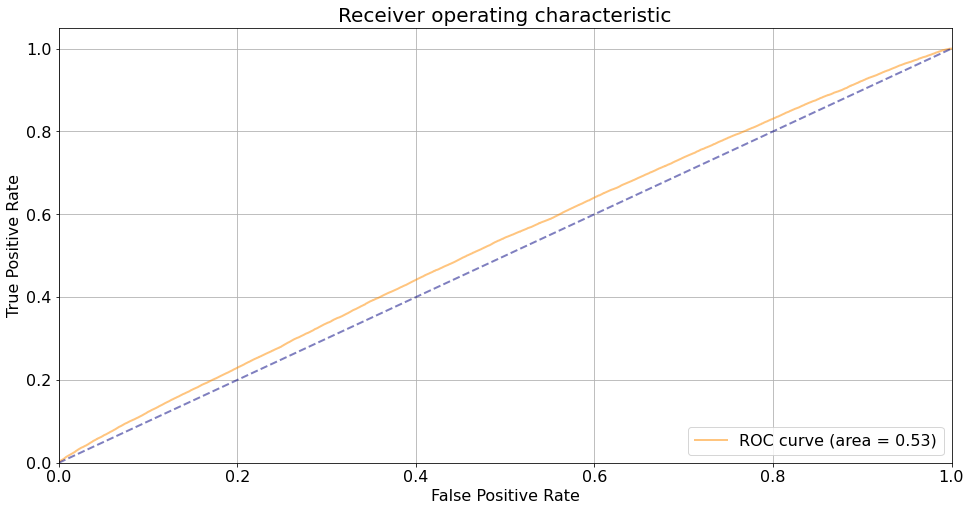

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [34]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

<Figure size 1152x576 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text major ticklabel objects>)

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Error Rate')

Text(0.5, 1.0, 'FPR-FNR curves')

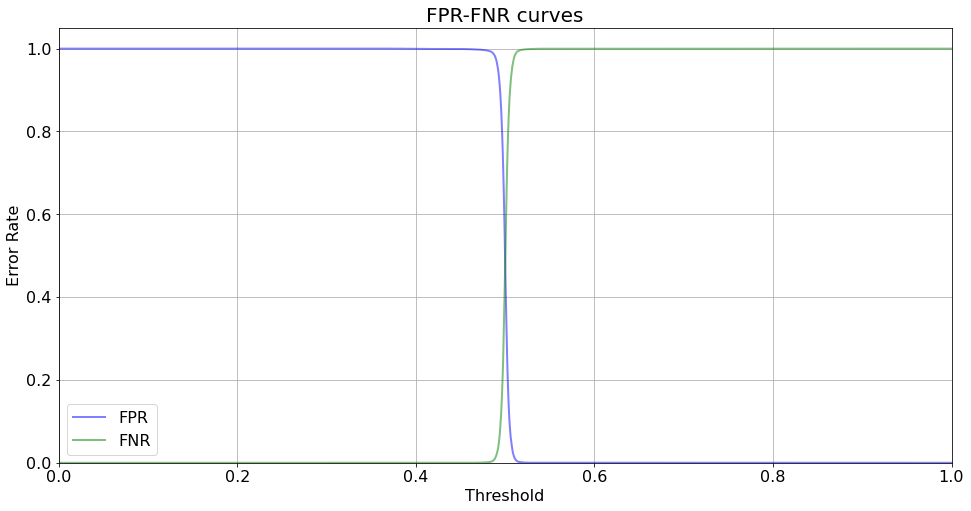

In [35]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [36]:
from catboost.utils import select_threshold

fnr_threshold = select_threshold(model=model, data=eval_pool, FNR=0.005)
fpr_threshold = select_threshold(model=model, data=eval_pool, FPR=0.005)
print(fnr_threshold)
print(fpr_threshold)

0.4865505357058888
0.5129555948407349


In [37]:
probas = model.predict_proba(data=X_validation)[:,1]
preds = model.predict(data=X_validation)
positive = np.where((preds==1))
print(f'Total predicted to be positive: {len(positive[0])} \n')

print("Matched draws\n")
matched_numbers = np.where((preds==1) & (y_validation ==1))
print(f"Count: {len(matched_numbers[0])},  {matched_numbers}")

print('\n\nAll matched')
month_data = feature_matrix.loc[feature_matrix['time'] == TARGET_MONTH]
numbers = month_data.iloc[matched_numbers[0]][['NumberId']]

print(origin_data[(origin_data['DrawDate'].dt.year == TARGET_MONTH.year) & 
                    (origin_data['DrawDate'].dt.month == TARGET_MONTH.month) &  
                    (origin_data['LuckyNo'].isin(numbers['NumberId']))].head(100))   
print(f"\nAverage: {np.average(probas[positive])}\n")
print(f"Probas: {probas[positive]}\n")
print(f"Matched probas: {probas[matched_numbers]}\n")


Total predicted to be positive: 865 

Matched draws

Count: 29,  (array([  55,  571,  618,  624,  875, 1299, 1340, 1701, 1789, 1851, 1870,
       2449, 2483, 2653, 2730, 3164, 3711, 3960, 5227, 6164, 6415, 7016,
       7673, 7706, 8358, 9083, 9108, 9526, 9593]),)


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
106835  505320 2020-01-01      1stPrizeNo      875
106856  505320 2020-01-01      SpecialNo8     3960
106859  505420 2020-01-04      2ndPrizeNo     2483
106876  505420 2020-01-04      SpecialNo5     2730
106882  505520 2020-01-05      2ndPrizeNo     8358
106893  505520 2020-01-05  ConsolationNo9      618
106896  505520 2020-01-05      SpecialNo2     9526
106917  505620 2020-01-08      SpecialNo1     5227
106929  505720 2020-01-11      3rdPrizeNo     6164
106936  505720 2020-01-11  ConsolationNo6     2653
106940  505720 2020-01-11      SpecialNo1     1701
106941  505720 2020-01-11     SpecialNo10     1851
106956  505820 2020-01-12  ConsolationNo3     1299
106965  

In [38]:
probas_fpr = np.where(probas > fpr_threshold)
total_draws = origin_data[(origin_data['DrawDate'].dt.year == TARGET_MONTH.year) & 
                    (origin_data['DrawDate'].dt.month == TARGET_MONTH.month)]['DrawDate'].nunique()
print(f"Total draws: {total_draws}")                    
print(f" Total predicted: {len(probas_fpr[0])}")
print(probas_fpr)
numbers = month_data.iloc[probas_fpr][['NumberId']]
print(origin_data[(origin_data['DrawDate'].dt.year == TARGET_MONTH.year) & 
                    (origin_data['DrawDate'].dt.month == TARGET_MONTH.month) &  
                    (origin_data['LuckyNo'].isin(numbers['NumberId']))].head(100))  

Total draws: 15
 Total predicted: 66
(array([  44,  254,  383,  442,  559,  571,  610,  768,  778, 1169, 1239,
       1322, 1458, 1577, 1782, 1888, 1894, 2056, 2059, 2129, 2153, 2158,
       2449, 2564, 2620, 2708, 2810, 3567, 3632, 3701, 4257, 4854, 4965,
       5007, 5070, 5074, 5307, 5338, 5512, 5707, 5858, 5983, 6485, 6681,
       6770, 7016, 7231, 7526, 7706, 7730, 7986, 8067, 8164, 8306, 8319,
       8580, 8925, 8957, 8983, 9013, 9161, 9364, 9471, 9478, 9702, 9796]),)
        DrawNo   DrawDate       PrizeType  LuckyNo
106984  505920 2020-01-15  ConsolationNo8     7706
106987  505920 2020-01-15     SpecialNo10     7016
106996  506020 2020-01-18      1stPrizeNo     2449
107128  506520 2020-01-26      SpecialNo4      571


In [39]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,MEAN(Results.TIME_SINCE(DrawDate)),7.111565
1,MIN(Results.PERCENTILE(DrawNo)),6.649620
2,MEAN(Results.CUM_MEAN(LuckyNo)),5.399648
3,MAX(Results.CUM_MEAN(LuckyNo)),4.742903
4,PERCENTILE(COUNT(Results)),4.449245
...,...,...
104,PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),0.000000
105,PERCENTILE(MEAN(Results.LuckyNo)),0.000000
106,PERCENTILE(SUM(Results.LuckyNo)),0.000000
107,PERCENTILE(STD(Results.DrawNo)),0.000000


In [40]:
"""
Class weight

from sklearn.utils import class_weight
cw = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df_train['Target']),
                                             df_train['Target']))
"""

"""
imbalanced-learn package
"""

"\nClass weight\n\nfrom sklearn.utils import class_weight\ncw = list(class_weight.compute_class_weight('balanced',\n                                             np.unique(df_train['Target']),\n                                             df_train['Target']))\n"

'\nimbalanced-learn package\n'